<h1 align=center>Homework 8</h1>
<br>
<div align=center>
$$
\textbf{Team G} \\ 
\text{Evangelou Sotiris 2159} \\ 
\text{Kalais Konstantinos 2146} \\ 
\text{Chatziefremidis Leuteris 2209} \\ 
$$
<div>

# $\triangleright$ Libraries

In [1]:
import pandas as pd
import os
from os import listdir
from os.path import isfile, join
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Activation
import numpy as np
import re

Using TensorFlow backend.


# $\triangleright$ Preprocessing the data

In [2]:
def clean_str(string):
    """
    Tokenization/string cleaning for all datasets except for SST.
    Original taken from https://github.com/yoonkim/CNN_sentence/blob/master/process_data.py
    """
    string = re.sub(r"[^A-Za-z0-9(),!?\'\`]", " ", string)
    string = re.sub(r"\'s", " \'s", string)
    string = re.sub(r"\'ve", " \'ve", string)
    string = re.sub(r"n\'t", " n\'t", string)
    string = re.sub(r"\'re", " \'re", string)
    string = re.sub(r"\'d", " \'d", string)
    string = re.sub(r"\'ll", " \'ll", string)
    string = re.sub(r",", " , ", string)
    string = re.sub(r"!", " ! ", string)
    string = re.sub(r"\(", " \( ", string)
    string = re.sub(r"\)", " \) ", string)
    string = re.sub(r"\?", " \? ", string)
    string = re.sub(r"\s{2,}", " ", string)
    return string.strip().lower()
def readAllTheFile(fileName):
    contents = ""
    with open(fileName) as f:
        for line in f.readlines():
            contents += line
    return contents
def createTheDataFrame(dirName):
    
     #Get the files from a directory
    files = [os.path.join(dirName,fi) for fi in os.listdir(dirName)]
    
    df = pd.DataFrame(columns=['message', 'label'])
    for f in files:
        
        #Read the message of the file
        messageFromFile =readAllTheFile(f)
        
        #Clear the string
        messageFromFile = clean_str(messageFromFile)
        
        #Check the category SPAM --> 1 OR MAIL --> 0
        filepathTokens = f.split('/')
        lastToken = filepathTokens[len(filepathTokens) - 1]
        if lastToken.startswith("sp"):
            lab = 1
        else:
            lab = 0
        
        #Pass a new row to dataframe
        row = [messageFromFile,lab]
        df.loc[len(df)] = row
    return df

# $\triangleright$ Vectorize the data and split them

In [3]:
#Create a dataframe with the samples for train,test
df=createTheDataFrame('./Emails')

#Vectorize the data
vectorizer = TfidfVectorizer()
print(df.head())

# Extract features
X = vectorizer.fit_transform(df.message).toarray()
# Extract targets
y = df.label.astype('int')

X = np.array(X)
y = np.array(y)

#Split to train,test
trainX,testX,trainY,testY = train_test_split(X, y, test_size=0.30, random_state=42)
print(trainX.shape,testX.shape)
print(trainX)

                                             message label
0  subject spanish association of applied linguis...     0
1  subject genetic classification i wish to make ...     0
2  subject functional phonology , paul boersma ne...     0
3  subject iscll3 the third international symposi...     0
4  subject multilingual ocr \( optical character ...     0
(561, 24862) (241, 24862)
[[0.33664014 0.42746101 0.         ... 0.         0.         0.        ]
 [0.04374908 0.06802284 0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.02926027 0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


#  $\triangleright$ Developing a code for doing neural networks with back propagation

In [6]:
# building our neural network
n_inputs, n_features = trainX.shape
n_hidden_neurons = 50
n_categories = 2

# we make the weights normally distributed using numpy.random.randn

# weights and bias in the hidden layer
hidden_weights = np.random.randn(n_features, n_hidden_neurons)
hidden_bias = np.zeros(n_hidden_neurons) + 0.01

# weights and bias in the output layer
output_weights = np.random.randn(n_hidden_neurons, n_categories)
output_bias = np.zeros(n_categories) + 0.01


# setup the feed-forward pass, subscript h = hidden layer

def sigmoid(x):
    return 1/(1 + np.exp(-x))

def feed_forward(X):
    # weighted sum of inputs to the hidden layer
    z_h = np.matmul(X, hidden_weights) + hidden_bias
    # activation in the hidden layer
    a_h = sigmoid(z_h)
    
    # weighted sum of inputs to the output layer
    z_o = np.matmul(a_h, output_weights) + output_bias
    # softmax output
    # axis 0 holds each input and axis 1 the probabilities of each category
    exp_term = np.exp(z_o)
    probabilities = exp_term / np.sum(exp_term, axis=1, keepdims=True)
    
    return probabilities

probabilities = feed_forward(trainX)
print("probabilities = (n_inputs, n_categories) = " + str(probabilities.shape))
print("probability that sample 0 is in category 0,1 \n" + str(probabilities[0]))
print("probabilities sum up to: " + str(probabilities[0].sum()))
print()

# we obtain a prediction by taking the class with the highest likelihood
def predict(X):
    probabilities = feed_forward(X)
    return np.argmax(probabilities, axis=1)

predictions = predict(trainX)
print("predictions = (n_inputs) = " + str(predictions.shape))
print("prediction for sample 0: " + str(predictions[0]))
print("correct label for sample 0: " + str(trainY[0]))


probabilities = (n_inputs, n_categories) = (561, 2)
probability that sample 0 is in category 0,1 
[0.16299495 0.83700505]
probabilities sum up to: 1.0

predictions = (n_inputs) = (561,)
prediction for sample 0: 1
correct label for sample 0: 1


# $\triangleright$ Optimizing the cost function

In [7]:
# to categorical turns our integer vector into a onehot representation
from sklearn.metrics import accuracy_score

# one-hot in numpy
def to_categorical_numpy(integer_vector):
    n_inputs = len(integer_vector)
    n_categories = np.max(integer_vector) + 1
    onehot_vector = np.zeros((n_inputs, n_categories))
    onehot_vector[range(n_inputs), integer_vector] = 1
    
    return onehot_vector

#Y_train_onehot, Y_test_onehot = to_categorical(Y_train), to_categorical(Y_test)
Y_train_onehot, Y_test_onehot = to_categorical_numpy(trainY), to_categorical_numpy(testY)

def feed_forward_train(X):
    # weighted sum of inputs to the hidden layer
    z_h = np.matmul(X, hidden_weights) + hidden_bias
    # activation in the hidden layer
    a_h = sigmoid(z_h)
    
    # weighted sum of inputs to the output layer
    z_o = np.matmul(a_h, output_weights) + output_bias
    # softmax output
    # axis 0 holds each input and axis 1 the probabilities of each category
    exp_term = np.exp(z_o)
    probabilities = exp_term / np.sum(exp_term, axis=1, keepdims=True)
    
    # for backpropagation need activations in hidden and output layers
    return a_h, probabilities

def backpropagation(X, Y):
    a_h, probabilities = feed_forward_train(X)
    
    # error in the output layer
    error_output = probabilities - Y
    # error in the hidden layer
    error_hidden = np.matmul(error_output, output_weights.T) * a_h * (1 - a_h)
    
    # gradients for the output layer
    output_weights_gradient = np.matmul(a_h.T, error_output)
    output_bias_gradient = np.sum(error_output, axis=0)
    
    # gradient for the hidden layer
    hidden_weights_gradient = np.matmul(X.T, error_hidden)
    hidden_bias_gradient = np.sum(error_hidden, axis=0)

    return output_weights_gradient, output_bias_gradient, hidden_weights_gradient, hidden_bias_gradient

print("Old accuracy on training data: " + str(accuracy_score(predict(trainX), trainY)))

eta = 0.01
lmbd = 0.01
for i in range(1000):
    # calculate gradients
    dWo, dBo, dWh, dBh = backpropagation(trainX, Y_train_onehot)
    
    # regularization term gradients
    dWo += lmbd * output_weights
    dWh += lmbd * hidden_weights
    
    # update weights and biases
    output_weights -= eta * dWo
    output_bias -= eta * dBo
    hidden_weights -= eta * dWh
    hidden_bias -= eta * dBh

print("New accuracy on training data: " + str(accuracy_score(predict(trainX), trainY)))

Old accuracy on training data: 0.46524064171123
New accuracy on training data: 1.0


# $\triangleright$ Full object-oriented implementation

In [8]:
class NeuralNetwork:
    def __init__(
        self,
        X_data,
        Y_data,
        n_hidden_neurons=50,
        n_categories=2,
        epochs=100,
        batch_size=1,
        eta=0.1,
        lmbd=0.0,

    ):
        self.X_data_full = X_data
        self.Y_data_full = Y_data

        self.n_inputs = X_data.shape[0]
        self.n_features = X_data.shape[1]
        self.n_hidden_neurons = n_hidden_neurons
        self.n_categories = n_categories

        self.epochs = epochs
        self.batch_size = batch_size
        self.iterations = self.n_inputs // self.batch_size
        self.eta = eta
        self.lmbd = lmbd

        self.create_biases_and_weights()

    def create_biases_and_weights(self):
        self.hidden_weights = np.random.randn(self.n_features, self.n_hidden_neurons)
        self.hidden_bias = np.zeros(self.n_hidden_neurons) + 0.01

        self.output_weights = np.random.randn(self.n_hidden_neurons, self.n_categories)
        self.output_bias = np.zeros(self.n_categories) + 0.01

    def feed_forward(self):
        # feed-forward for training
        self.z_h = np.matmul(self.X_data, self.hidden_weights) + self.hidden_bias
        self.a_h = sigmoid(self.z_h)

        self.z_o = np.matmul(self.a_h, self.output_weights) + self.output_bias

        exp_term = np.exp(self.z_o)
        self.probabilities = exp_term / np.sum(exp_term, axis=1, keepdims=True)

    def feed_forward_out(self, X):
        # feed-forward for output
        z_h = np.matmul(X, self.hidden_weights) + self.hidden_bias
        a_h = sigmoid(z_h)

        z_o = np.matmul(a_h, self.output_weights) + self.output_bias
        
        exp_term = np.exp(z_o)
        probabilities = exp_term / np.sum(exp_term, axis=1, keepdims=True)
        return probabilities

    def backpropagation(self):
        error_output = self.probabilities - self.Y_data
        error_hidden = np.matmul(error_output, self.output_weights.T) * self.a_h * (1 - self.a_h)

        self.output_weights_gradient = np.matmul(self.a_h.T, error_output)
        self.output_bias_gradient = np.sum(error_output, axis=0)

        self.hidden_weights_gradient = np.matmul(self.X_data.T, error_hidden)
        self.hidden_bias_gradient = np.sum(error_hidden, axis=0)

        if self.lmbd > 0.0:
            self.output_weights_gradient += self.lmbd * self.output_weights
            self.hidden_weights_gradient += self.lmbd * self.hidden_weights

        self.output_weights -= self.eta * self.output_weights_gradient
        self.output_bias -= self.eta * self.output_bias_gradient
        self.hidden_weights -= self.eta * self.hidden_weights_gradient
        self.hidden_bias -= self.eta * self.hidden_bias_gradient

    def predict(self, X):
        probabilities = self.feed_forward_out(X)
        return np.argmax(probabilities, axis=1)

    def predict_probabilities(self, X):
        probabilities = self.feed_forward_out(X)
        return probabilities

    def train(self):
        data_indices = np.arange(self.n_inputs)

        for i in range(self.epochs):
            for j in range(self.iterations):
                # pick datapoints with replacement
                chosen_datapoints = np.random.choice(
                    data_indices, size=self.batch_size, replace=False
                )

                # minibatch training data
                self.X_data = self.X_data_full[chosen_datapoints]
                self.Y_data = self.Y_data_full[chosen_datapoints]

                self.feed_forward()
                self.backpropagation()

# $\triangleright$ Evaluate model performance on test data

In [9]:
epochs = 100
batch_size = 100

dnn = NeuralNetwork(trainX, Y_train_onehot, eta=eta, lmbd=lmbd, epochs=epochs, batch_size=batch_size,
                    n_hidden_neurons=n_hidden_neurons, n_categories=n_categories)
dnn.train()
test_predict = dnn.predict(testX)

# accuracy score from scikit library
print("Accuracy score on test set: ", accuracy_score(testY, test_predict))

# equivalent in numpy
def accuracy_score_numpy(Y_test, Y_pred):
    return np.sum(Y_test == Y_pred) / len(Y_test)

#print("Accuracy score on test set: ", accuracy_score_numpy(Y_test, test_predict))

Accuracy score on test set:  0.946058091286307


# $\triangleright$  Adjust hyperparameters

In [10]:
eta_vals = np.logspace(-5, 1, 7)
lmbd_vals = np.logspace(-5, 1, 7)
# store the models for later use
DNN_numpy = np.zeros((len(eta_vals), len(lmbd_vals)), dtype=object)

# grid search
for i, eta in enumerate(eta_vals):
    for j, lmbd in enumerate(lmbd_vals):
        dnn = NeuralNetwork(trainX, Y_train_onehot, eta=eta, lmbd=lmbd, epochs=epochs, batch_size=batch_size,
                            n_hidden_neurons=n_hidden_neurons, n_categories=n_categories)
        dnn.train()
        
        DNN_numpy[i][j] = dnn
        
        test_predict = dnn.predict(testX)
        
        print("Learning rate  = ", eta)
        print("Lambda = ", lmbd)
        print("Accuracy score on test set: ", accuracy_score(testY, test_predict))
        print()

Learning rate  =  1e-05
Lambda =  1e-05
Accuracy score on test set:  0.3983402489626556

Learning rate  =  1e-05
Lambda =  0.0001
Accuracy score on test set:  0.4730290456431535

Learning rate  =  1e-05
Lambda =  0.001
Accuracy score on test set:  0.4107883817427386

Learning rate  =  1e-05
Lambda =  0.01
Accuracy score on test set:  0.48132780082987553

Learning rate  =  1e-05
Lambda =  0.1
Accuracy score on test set:  0.4605809128630705

Learning rate  =  1e-05
Lambda =  1.0
Accuracy score on test set:  0.5477178423236515

Learning rate  =  1e-05
Lambda =  10.0
Accuracy score on test set:  0.4730290456431535

Learning rate  =  0.0001
Lambda =  1e-05
Accuracy score on test set:  0.5892116182572614

Learning rate  =  0.0001
Lambda =  0.0001
Accuracy score on test set:  0.5892116182572614

Learning rate  =  0.0001
Lambda =  0.001
Accuracy score on test set:  0.5809128630705395

Learning rate  =  0.0001
Lambda =  0.01
Accuracy score on test set:  0.5186721991701245

Learning rate  =  0.0

/home/echatzief/.local/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: overflow encountered in exp


Learning rate  =  1.0
Lambda =  1e-05
Accuracy score on test set:  0.4896265560165975



/home/echatzief/.local/lib/python3.6/site-packages/ipykernel_launcher.py:44: RuntimeWarning: overflow encountered in exp
/home/echatzief/.local/lib/python3.6/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in true_divide


Learning rate  =  1.0
Lambda =  0.0001
Accuracy score on test set:  0.5103734439834025

Learning rate  =  1.0
Lambda =  0.001
Accuracy score on test set:  0.5103734439834025

Learning rate  =  1.0
Lambda =  0.01
Accuracy score on test set:  0.5103734439834025

Learning rate  =  1.0
Lambda =  0.1
Accuracy score on test set:  0.5103734439834025

Learning rate  =  1.0
Lambda =  1.0
Accuracy score on test set:  0.5103734439834025

Learning rate  =  1.0
Lambda =  10.0
Accuracy score on test set:  0.5103734439834025

Learning rate  =  10.0
Lambda =  1e-05
Accuracy score on test set:  0.5103734439834025

Learning rate  =  10.0
Lambda =  0.0001
Accuracy score on test set:  0.5103734439834025

Learning rate  =  10.0
Lambda =  0.001
Accuracy score on test set:  0.5103734439834025

Learning rate  =  10.0
Lambda =  0.01
Accuracy score on test set:  0.5103734439834025

Learning rate  =  10.0
Lambda =  0.1
Accuracy score on test set:  0.5103734439834025

Learning rate  =  10.0
Lambda =  1.0
Accuracy

# $\triangleright$  Visualization

/home/echatzief/.local/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: overflow encountered in exp


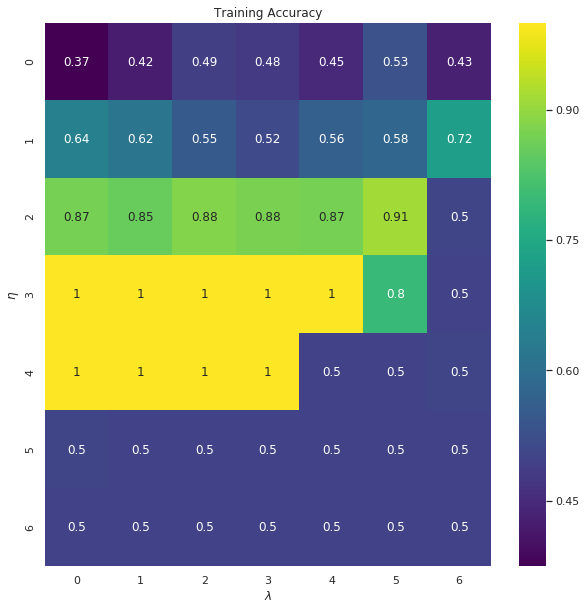

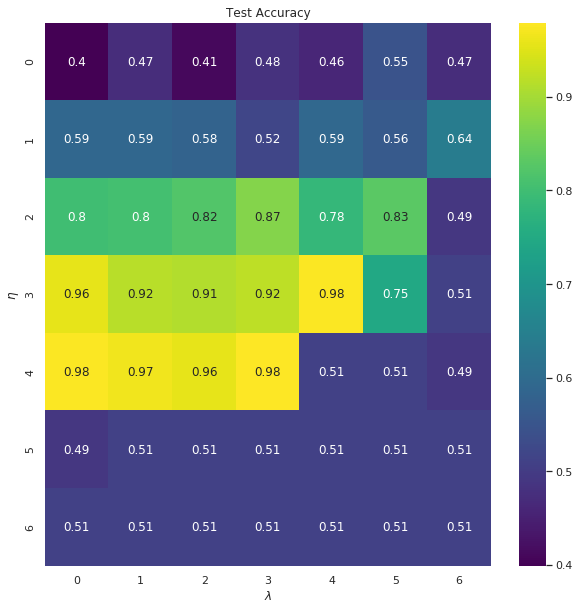

In [12]:
# visual representation of grid search
# uses seaborn heatmap, you can also do this with matplotlib imshow
import seaborn as sns
import matplotlib.pyplot as plt 
sns.set()

train_accuracy = np.zeros((len(eta_vals), len(lmbd_vals)))
test_accuracy = np.zeros((len(eta_vals), len(lmbd_vals)))

for i in range(len(eta_vals)):
    for j in range(len(lmbd_vals)):
        dnn = DNN_numpy[i][j]
        
        train_pred = dnn.predict(trainX) 
        test_pred = dnn.predict(testX)

        train_accuracy[i][j] = accuracy_score(trainY, train_pred)
        test_accuracy[i][j] = accuracy_score(testY, test_pred)

        
fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(train_accuracy, annot=True, ax=ax, cmap="viridis")
ax.set_title("Training Accuracy")
ax.set_ylabel("$\eta$")
ax.set_xlabel("$\lambda$")
plt.show()

fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(test_accuracy, annot=True, ax=ax, cmap="viridis")
ax.set_title("Test Accuracy")
ax.set_ylabel("$\eta$")
ax.set_xlabel("$\lambda$")
plt.show()

# $\triangleright$ Scikit-Learn implementation

In [13]:
from sklearn.neural_network import MLPClassifier
# store models for later use
DNN_scikit = np.zeros((len(eta_vals), len(lmbd_vals)), dtype=object)

for i, eta in enumerate(eta_vals):
    for j, lmbd in enumerate(lmbd_vals):
        dnn = MLPClassifier(hidden_layer_sizes=(n_hidden_neurons), activation='logistic',
                            alpha=lmbd, learning_rate_init=eta, max_iter=epochs)
        dnn.fit(trainX, trainY)
        
        DNN_scikit[i][j] = dnn
        
        print("Learning rate  = ", eta)
        print("Lambda = ", lmbd)
        print("Accuracy score on test set: ", dnn.score(testX, testY))
        print()

/home/echatzief/.local/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Learning rate  =  1e-05
Lambda =  1e-05
Accuracy score on test set:  0.5103734439834025



/home/echatzief/.local/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Learning rate  =  1e-05
Lambda =  0.0001
Accuracy score on test set:  0.4896265560165975



/home/echatzief/.local/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Learning rate  =  1e-05
Lambda =  0.001
Accuracy score on test set:  0.5103734439834025



/home/echatzief/.local/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Learning rate  =  1e-05
Lambda =  0.01
Accuracy score on test set:  0.4896265560165975



/home/echatzief/.local/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Learning rate  =  1e-05
Lambda =  0.1
Accuracy score on test set:  0.5103734439834025



/home/echatzief/.local/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Learning rate  =  1e-05
Lambda =  1.0
Accuracy score on test set:  0.4896265560165975



/home/echatzief/.local/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Learning rate  =  1e-05
Lambda =  10.0
Accuracy score on test set:  0.5103734439834025



/home/echatzief/.local/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Learning rate  =  0.0001
Lambda =  1e-05
Accuracy score on test set:  0.979253112033195



/home/echatzief/.local/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Learning rate  =  0.0001
Lambda =  0.0001
Accuracy score on test set:  0.8257261410788381



/home/echatzief/.local/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Learning rate  =  0.0001
Lambda =  0.001
Accuracy score on test set:  0.9875518672199171



/home/echatzief/.local/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Learning rate  =  0.0001
Lambda =  0.01
Accuracy score on test set:  0.983402489626556



/home/echatzief/.local/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Learning rate  =  0.0001
Lambda =  0.1
Accuracy score on test set:  0.950207468879668

Learning rate  =  0.0001
Lambda =  1.0
Accuracy score on test set:  0.9875518672199171

Learning rate  =  0.0001
Lambda =  10.0
Accuracy score on test set:  0.4896265560165975



/home/echatzief/.local/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Learning rate  =  0.001
Lambda =  1e-05
Accuracy score on test set:  0.991701244813278



/home/echatzief/.local/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Learning rate  =  0.001
Lambda =  0.0001
Accuracy score on test set:  0.991701244813278



/home/echatzief/.local/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Learning rate  =  0.001
Lambda =  0.001
Accuracy score on test set:  0.991701244813278



/home/echatzief/.local/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Learning rate  =  0.001
Lambda =  0.01
Accuracy score on test set:  0.991701244813278



/home/echatzief/.local/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Learning rate  =  0.001
Lambda =  0.1
Accuracy score on test set:  0.9875518672199171



/home/echatzief/.local/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Learning rate  =  0.001
Lambda =  1.0
Accuracy score on test set:  0.9585062240663901



/home/echatzief/.local/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Learning rate  =  0.001
Lambda =  10.0
Accuracy score on test set:  0.4896265560165975

Learning rate  =  0.01
Lambda =  1e-05
Accuracy score on test set:  0.995850622406639

Learning rate  =  0.01
Lambda =  0.0001
Accuracy score on test set:  0.991701244813278



/home/echatzief/.local/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Learning rate  =  0.01
Lambda =  0.001
Accuracy score on test set:  0.995850622406639



/home/echatzief/.local/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Learning rate  =  0.01
Lambda =  0.01
Accuracy score on test set:  0.9875518672199171



/home/echatzief/.local/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Learning rate  =  0.01
Lambda =  0.1
Accuracy score on test set:  0.9875518672199171



/home/echatzief/.local/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Learning rate  =  0.01
Lambda =  1.0
Accuracy score on test set:  0.979253112033195

Learning rate  =  0.01
Lambda =  10.0
Accuracy score on test set:  0.4896265560165975

Learning rate  =  0.1
Lambda =  1e-05
Accuracy score on test set:  0.983402489626556

Learning rate  =  0.1
Lambda =  0.0001
Accuracy score on test set:  0.995850622406639

Learning rate  =  0.1
Lambda =  0.001
Accuracy score on test set:  0.991701244813278

Learning rate  =  0.1
Lambda =  0.01
Accuracy score on test set:  0.991701244813278

Learning rate  =  0.1
Lambda =  0.1
Accuracy score on test set:  0.991701244813278

Learning rate  =  0.1
Lambda =  1.0
Accuracy score on test set:  0.983402489626556

Learning rate  =  0.1
Lambda =  10.0
Accuracy score on test set:  0.5103734439834025



/home/echatzief/.local/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Learning rate  =  1.0
Lambda =  1e-05
Accuracy score on test set:  0.979253112033195



/home/echatzief/.local/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Learning rate  =  1.0
Lambda =  0.0001
Accuracy score on test set:  0.983402489626556

Learning rate  =  1.0
Lambda =  0.001
Accuracy score on test set:  0.983402489626556

Learning rate  =  1.0
Lambda =  0.01
Accuracy score on test set:  0.983402489626556

Learning rate  =  1.0
Lambda =  0.1
Accuracy score on test set:  0.9585062240663901

Learning rate  =  1.0
Lambda =  1.0
Accuracy score on test set:  0.4896265560165975

Learning rate  =  1.0
Lambda =  10.0
Accuracy score on test set:  0.4896265560165975

Learning rate  =  10.0
Lambda =  1e-05
Accuracy score on test set:  0.983402489626556

Learning rate  =  10.0
Lambda =  0.0001
Accuracy score on test set:  0.983402489626556

Learning rate  =  10.0
Lambda =  0.001
Accuracy score on test set:  0.4896265560165975

Learning rate  =  10.0
Lambda =  0.01
Accuracy score on test set:  0.5103734439834025

Learning rate  =  10.0
Lambda =  0.1
Accuracy score on test set:  0.5103734439834025

Learning rate  =  10.0
Lambda =  1.0
Accuracy scor

# $\triangleright$ Visualization

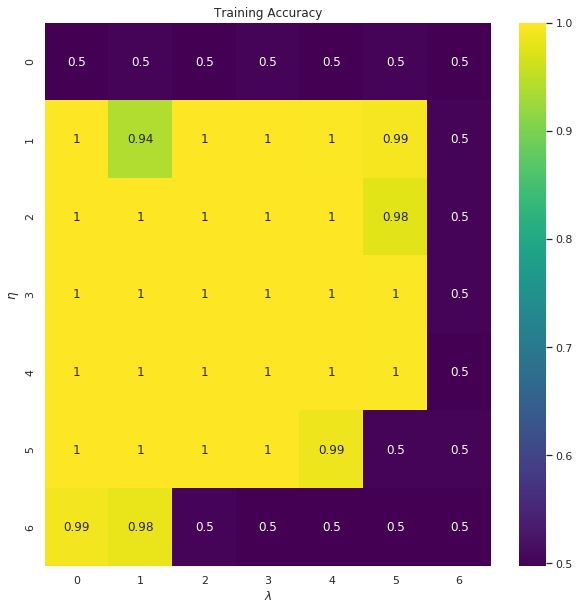

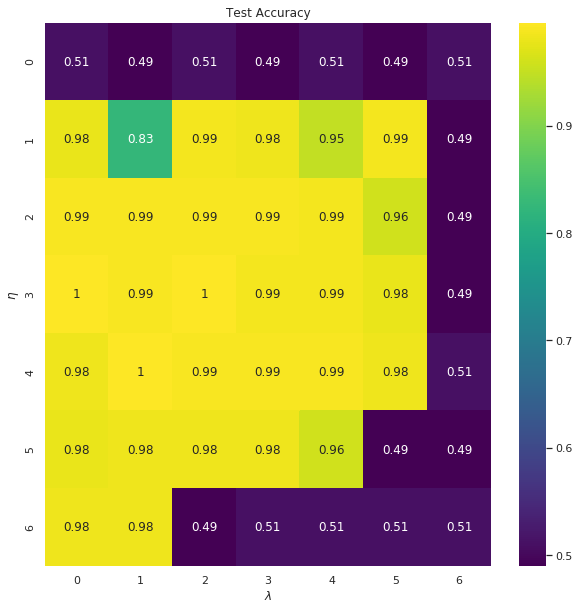

In [14]:
# optional
# visual representation of grid search
# uses seaborn heatmap, could probably do this in matplotlib
import seaborn as sns

sns.set()

train_accuracy = np.zeros((len(eta_vals), len(lmbd_vals)))
test_accuracy = np.zeros((len(eta_vals), len(lmbd_vals)))

for i in range(len(eta_vals)):
    for j in range(len(lmbd_vals)):
        dnn = DNN_scikit[i][j]
        
        train_pred = dnn.predict(trainX) 
        test_pred = dnn.predict(testX)

        train_accuracy[i][j] = accuracy_score(trainY, train_pred)
        test_accuracy[i][j] = accuracy_score(testY, test_pred)

        
fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(train_accuracy, annot=True, ax=ax, cmap="viridis")
ax.set_title("Training Accuracy")
ax.set_ylabel("$\eta$")
ax.set_xlabel("$\lambda$")
plt.show()

fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(test_accuracy, annot=True, ax=ax, cmap="viridis")
ax.set_title("Test Accuracy")
ax.set_ylabel("$\eta$")
ax.set_xlabel("$\lambda$")
plt.show()

# $\triangleright$ Using tensorflow

In [15]:
import tensorflow as tf

class NeuralNetworkTensorflow:
    def __init__(
        self,
        X_train,
        Y_train,
        X_test,
        Y_test,
        n_neurons_layer1=100,
        n_neurons_layer2=50,
        n_categories=1,
        epochs=10,
        batch_size=100,
        eta=0.1,
        lmbd=0.0,
    ):
        
        # keep track of number of steps
        self.global_step = tf.Variable(0, dtype=tf.int32, trainable=False, name='global_step')
        
        self.X_train = X_train
        self.Y_train = Y_train
        self.X_test = X_test
        self.Y_test = Y_test
        
        self.n_inputs = X_train.shape[0]
        self.n_features = X_train.shape[1]
        self.n_neurons_layer1 = n_neurons_layer1
        self.n_neurons_layer2 = n_neurons_layer2
        self.n_categories = n_categories
        
        self.epochs = epochs
        self.batch_size = batch_size
        self.iterations = self.n_inputs // self.batch_size
        self.eta = eta
        self.lmbd = lmbd
        
        # build network piece by piece
        # name scopes (with) are used to enforce creation of new variables
        # https://www.tensorflow.org/guide/variables
        self.create_placeholders()
        self.create_DNN()
        self.create_loss()
        self.create_optimiser()
        self.create_accuracy()
    
    def create_placeholders(self):
        # placeholders are fine here, but "Datasets" are the preferred method
        # of streaming data into a model
        with tf.name_scope('data'):
            self.X = tf.placeholder(tf.float32, shape=(None, self.n_features), name='X_data')
            self.Y = tf.placeholder(tf.float32, shape=(None, self.n_categories), name='Y_data')
    
    def create_DNN(self):
        with tf.name_scope('DNN'):
            # the weights are stored to calculate regularization loss later
            
            # Fully connected layer 1
            self.W_fc1 = self.weight_variable([self.n_features, self.n_neurons_layer1], name='fc1', dtype=tf.float32)
            b_fc1 = self.bias_variable([self.n_neurons_layer1], name='fc1', dtype=tf.float32)
            a_fc1 = tf.nn.sigmoid(tf.matmul(self.X, self.W_fc1) + b_fc1)
            
            # Fully connected layer 2
            self.W_fc2 = self.weight_variable([self.n_neurons_layer1, self.n_neurons_layer2], name='fc2', dtype=tf.float32)
            b_fc2 = self.bias_variable([self.n_neurons_layer2], name='fc2', dtype=tf.float32)
            a_fc2 = tf.nn.sigmoid(tf.matmul(a_fc1, self.W_fc2) + b_fc2)
            
            # Output layer
            self.W_out = self.weight_variable([self.n_neurons_layer2, self.n_categories], name='out', dtype=tf.float32)
            b_out = self.bias_variable([self.n_categories], name='out', dtype=tf.float32)
            self.z_out = tf.matmul(a_fc2, self.W_out) + b_out
    
    def create_loss(self):
        with tf.name_scope('loss'):
            softmax_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=self.Y, logits=self.z_out))
            
            regularizer_loss_fc1 = tf.nn.l2_loss(self.W_fc1)
            regularizer_loss_fc2 = tf.nn.l2_loss(self.W_fc2)
            regularizer_loss_out = tf.nn.l2_loss(self.W_out)
            regularizer_loss = self.lmbd*(regularizer_loss_fc1 + regularizer_loss_fc2 + regularizer_loss_out)
            
            self.loss = softmax_loss + regularizer_loss

    def create_accuracy(self):
        with tf.name_scope('accuracy'):
            probabilities = tf.nn.softmax(self.z_out)
            predictions = tf.argmax(probabilities, axis=1)
            labels = tf.argmax(self.Y, axis=1)
            
            correct_predictions = tf.equal(predictions, labels)
            correct_predictions = tf.cast(correct_predictions, tf.float32)
            self.accuracy = tf.reduce_mean(correct_predictions)
    
    def create_optimiser(self):
        with tf.name_scope('optimizer'):
            self.optimizer = tf.train.GradientDescentOptimizer(learning_rate=self.eta).minimize(self.loss, global_step=self.global_step)
            
    def weight_variable(self, shape, name='', dtype=tf.float32):
        initial = tf.truncated_normal(shape, stddev=0.1)
        return tf.Variable(initial, name=name, dtype=dtype)
    
    def bias_variable(self, shape, name='', dtype=tf.float32):
        initial = tf.constant(0.1, shape=shape)
        return tf.Variable(initial, name=name, dtype=dtype)
    
    def fit(self):
        data_indices = np.arange(self.n_inputs)

        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            for i in range(self.epochs):
                for j in range(self.iterations):
                    chosen_datapoints = np.random.choice(data_indices, size=self.batch_size, replace=False)
                    batch_X, batch_Y = self.X_train[chosen_datapoints], self.Y_train[chosen_datapoints]
                    
                    #Fucking reshape
                    batch_Y = batch_Y.reshape(self.batch_size,n_categories)
                    sess.run([DNN.loss, DNN.optimizer],
                        feed_dict={DNN.X: batch_X,
                                   DNN.Y: batch_Y})
                    accuracy = sess.run(DNN.accuracy,
                        feed_dict={DNN.X: batch_X,
                                   DNN.Y: batch_Y})
                    step = sess.run(DNN.global_step)
            
            self.Y_train = self.Y_train.reshape(len(self.Y_train),n_categories)
            self.train_loss, self.train_accuracy = sess.run([DNN.loss, DNN.accuracy],
                feed_dict={DNN.X: self.X_train,
                           DNN.Y: self.Y_train})
            self.Y_test = self.Y_test.reshape(len(self.Y_test),n_categories)
            self.test_loss, self.test_accuracy = sess.run([DNN.loss, DNN.accuracy],
                feed_dict={DNN.X: self.X_test,
                           DNN.Y: self.Y_test})

# $\triangleright$ Tweaking Parameters

In [16]:
epochs = 100
batch_size = 100
n_neurons_layer1 = 100
n_neurons_layer2 = 50
n_categories = 1
eta_vals = np.logspace(-5, 1, 7)
lmbd_vals = np.logspace(-5, 1, 7)

DNN_tf = np.zeros((len(eta_vals), len(lmbd_vals)), dtype=object)
        
for i, eta in enumerate(eta_vals):
    for j, lmbd in enumerate(lmbd_vals):
        DNN = NeuralNetworkTensorflow(trainX, trainY, testX, testY,
                                      n_neurons_layer1, n_neurons_layer2, n_categories,
                                      epochs=epochs, batch_size=batch_size, eta=eta, lmbd=lmbd)
        DNN.fit()
        
        DNN_tf[i][j] = DNN
        
        print("Learning rate = ", eta)
        print("Lambda = ", lmbd)
        print("Test accuracy: %.3f" % DNN.test_accuracy)
        print()

Instructions for updating:
Colocations handled automatically by placer.
Learning rate =  1e-05
Lambda =  1e-05
Test accuracy: 1.000

Learning rate =  1e-05
Lambda =  0.0001
Test accuracy: 1.000

Learning rate =  1e-05
Lambda =  0.001
Test accuracy: 1.000

Learning rate =  1e-05
Lambda =  0.01
Test accuracy: 1.000

Learning rate =  1e-05
Lambda =  0.1
Test accuracy: 1.000

Learning rate =  1e-05
Lambda =  1.0
Test accuracy: 1.000

Learning rate =  1e-05
Lambda =  10.0
Test accuracy: 1.000

Learning rate =  0.0001
Lambda =  1e-05
Test accuracy: 1.000

Learning rate =  0.0001
Lambda =  0.0001
Test accuracy: 1.000

Learning rate =  0.0001
Lambda =  0.001
Test accuracy: 1.000

Learning rate =  0.0001
Lambda =  0.01
Test accuracy: 1.000

Learning rate =  0.0001
Lambda =  0.1
Test accuracy: 1.000

Learning rate =  0.0001
Lambda =  1.0
Test accuracy: 1.000

Learning rate =  0.0001
Lambda =  10.0
Test accuracy: 1.000

Learning rate =  0.001
Lambda =  1e-05
Test accuracy: 1.000

Learning rate = 

# $\triangleright$ Visualization

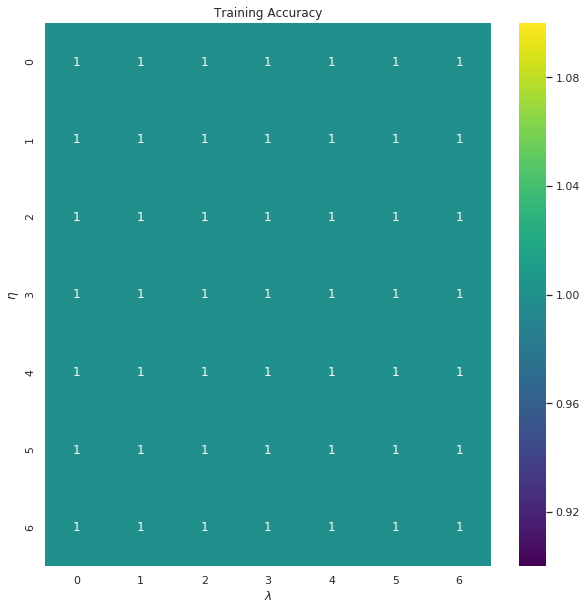

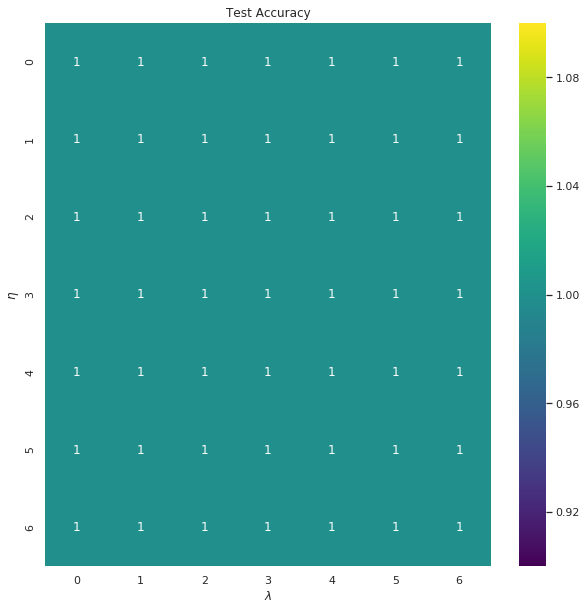

In [17]:
# optional
# visual representation of grid search
# uses seaborn heatmap, could probably do this in matplotlib
import seaborn as sns

sns.set()

train_accuracy = np.zeros((len(eta_vals), len(lmbd_vals)))
test_accuracy = np.zeros((len(eta_vals), len(lmbd_vals)))

for i in range(len(eta_vals)):
    for j in range(len(lmbd_vals)):
        DNN = DNN_tf[i][j]

        train_accuracy[i][j] = DNN.train_accuracy
        test_accuracy[i][j] = DNN.test_accuracy

        
fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(train_accuracy, annot=True, ax=ax, cmap="viridis")
ax.set_title("Training Accuracy")
ax.set_ylabel("$\eta$")
ax.set_xlabel("$\lambda$")
plt.show()

fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(test_accuracy, annot=True, ax=ax, cmap="viridis")
ax.set_title("Test Accuracy")
ax.set_ylabel("$\eta$")
ax.set_xlabel("$\lambda$")
plt.show()

# $\triangleright$ Using Keras

In [18]:
from keras.models import Sequential
from keras.layers import Dense
from keras.regularizers import l2
from keras.optimizers import SGD
def create_neural_network_keras(n_neurons_layer, n_categories, eta, lmbd,trainX):
    model = Sequential()
    model.add(Dense(n_neurons_layer,input_dim=trainX.shape[1],activation='relu', kernel_regularizer=l2(lmbd)))
    model.add(Dense(n_categories, activation='sigmoid'))
    
    sgd = SGD(lr=eta)
    model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])
    
    return model

# $\triangleright$ Tweaking Parameters

In [19]:
epochs = 100
batch_size = 100
n_neurons_layer = 20 
n_categories = 1
eta_vals = np.logspace(-5, 1, 7)
lmbd_vals = np.logspace(-5, 1, 7)

DNN_keras = np.zeros((len(eta_vals), len(lmbd_vals)), dtype=object)
        
for i, eta in enumerate(eta_vals):
    for j, lmbd in enumerate(lmbd_vals):
        DNN = create_neural_network_keras(n_neurons_layer,n_categories,eta=eta, lmbd=lmbd,trainX=trainX)
        DNN.fit(trainX, trainY, epochs=epochs, batch_size=batch_size, verbose=0)
        scores = DNN.evaluate(testX, testY)
        
        DNN_keras[i][j] = DNN
        
        print("Learning rate = ", eta)
        print("Lambda = ", lmbd)
        print("Test accuracy: %.3f" % scores[1])
        print()

Instructions for updating:
Use tf.cast instead.
241/241 [==============================] - 1s 2ms/step
Learning rate =  1e-05
Lambda =  1e-05
Test accuracy: 0.461

241/241 [==============================] - 0s 2ms/step
Learning rate =  1e-05
Lambda =  0.0001
Test accuracy: 0.498

241/241 [==============================] - 1s 2ms/step
Learning rate =  1e-05
Lambda =  0.001
Test accuracy: 0.535

241/241 [==============================] - 1s 3ms/step
Learning rate =  1e-05
Lambda =  0.01
Test accuracy: 0.502

241/241 [==============================] - 1s 2ms/step
Learning rate =  1e-05
Lambda =  0.1
Test accuracy: 0.394

241/241 [==============================] - 1s 3ms/step
Learning rate =  1e-05
Lambda =  1.0
Test accuracy: 0.436

241/241 [==============================] - 1s 3ms/step
Learning rate =  1e-05
Lambda =  10.0
Test accuracy: 0.461

241/241 [==============================] - 1s 3ms/step
Learning rate =  0.0001
Lambda =  1e-05
Test accuracy: 0.523

241/241 [===================

# $\triangleright$ Visualization

241/241 [==============================] - 0s 219us/step


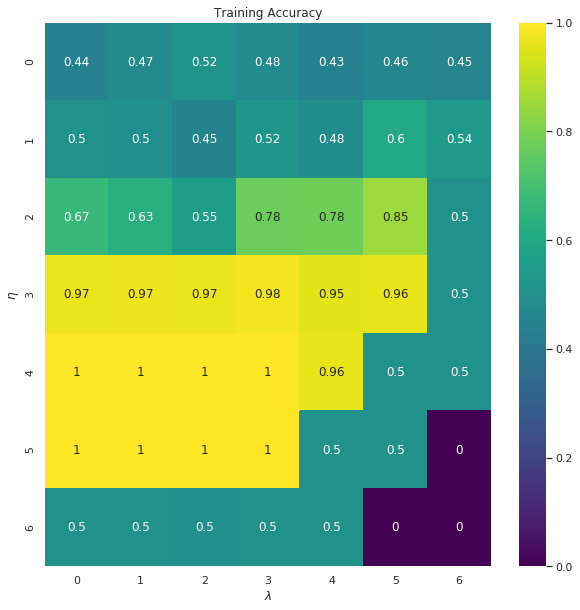

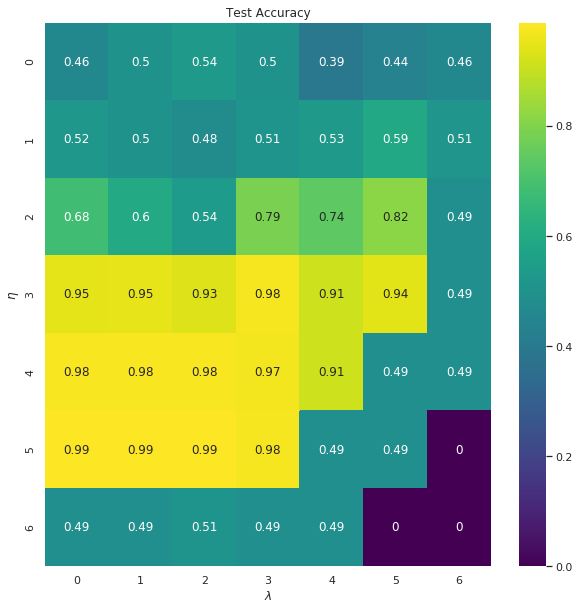

In [20]:
# optional
# visual representation of grid search
# uses seaborn heatmap, could probably do this in matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

train_accuracy = np.zeros((len(eta_vals), len(lmbd_vals)))
test_accuracy = np.zeros((len(eta_vals), len(lmbd_vals)))
for i in range(len(eta_vals)):
    for j in range(len(lmbd_vals)):
        DNN = DNN_keras[i][j]

        train_accuracy[i][j] = DNN.evaluate(trainX, trainY)[1]
        test_accuracy[i][j] = DNN.evaluate(testX, testY)[1]

        
fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(train_accuracy, annot=True, ax=ax, cmap="viridis")
ax.set_title("Training Accuracy")
ax.set_ylabel("$\eta$")
ax.set_xlabel("$\lambda$")
plt.show()

fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(test_accuracy, annot=True, ax=ax, cmap="viridis")
ax.set_title("Test Accuracy")
ax.set_ylabel("$\eta$")
ax.set_xlabel("$\lambda$")
plt.show()

# Simple Convolutional Network with Keras

In [21]:
"""
    Libraries
"""
import pandas as pd
import numpy as np
import re
import os
from os import listdir
from os.path import isfile,join
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Flatten,Dense,Input
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.preprocessing.sequence import pad_sequences
from keras import optimizers

## $\triangleright$ Preprocessing

In [22]:
#Create the DataFrame from the files
df = createTheDataFrame('./Emails');
print("\nHead of the DataFrame: ")
print(str(df.head())+"\n")

#Vectorize the data
vectorizer = TfidfVectorizer()

#Extract features,targets
X = np.array(vectorizer.fit_transform(df.message).toarray())
y = np.array(df.label.astype('int'))

#Train-test Spliting
trainX,testX,trainY,testY = train_test_split(X, y, test_size=0.30, random_state=42)

print("\nTrain X Shape: ",trainX.shape)
print("\nTrain Y Shape: ",trainY.shape)

#Reshape the data to insert it to convolutional network
trainX = np.reshape(trainX,(trainX.shape[0],trainX.shape[1],1))
trainY = np.reshape(trainY,(trainX.shape[0],1))
testX = np.reshape(testX,(testX.shape[0],testX.shape[1],1))
testY = np.reshape(testY,(testY.shape[0],1))



Head of the DataFrame: 
                                             message label
0  subject spanish association of applied linguis...     0
1  subject genetic classification i wish to make ...     0
2  subject functional phonology , paul boersma ne...     0
3  subject iscll3 the third international symposi...     0
4  subject multilingual ocr \( optical character ...     0


Train X Shape:  (561, 24862)

Train Y Shape:  (561,)


## $\triangleright$ The Model

In [23]:
"""
    Create the model
"""
model = Sequential()

model.add(Conv1D(5,1,input_shape=(trainX.shape[1],trainX.shape[2]),activation='relu',padding='same'))
model.add(Flatten())
model.add(Dense(5,activation='relu'))
model.add(Dense(1,activation='sigmoid'))

#sgd = optimizers.SGD(lr=0.0001)
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['acc'])

model.fit(trainX,trainY,validation_data=(testX,testY),epochs=30,batch_size=1)

Train on 561 samples, validate on 241 samples
Epoch 1/30
561/561 [==============================] - 12s 21ms/step - loss: 0.5250 - acc: 0.8699 - val_loss: 0.2019 - val_acc: 0.9917
Epoch 2/30
561/561 [==============================] - 7s 13ms/step - loss: 0.0792 - acc: 0.9982 - val_loss: 0.0556 - val_acc: 0.9959
Epoch 3/30
561/561 [==============================] - 8s 13ms/step - loss: 0.0153 - acc: 1.0000 - val_loss: 0.0432 - val_acc: 0.9959
Epoch 4/30
561/561 [==============================] - 9s 15ms/step - loss: 0.0055 - acc: 1.0000 - val_loss: 0.0296 - val_acc: 0.9917
Epoch 5/30
561/561 [==============================] - 9s 16ms/step - loss: 0.0028 - acc: 1.0000 - val_loss: 0.0245 - val_acc: 0.9959
Epoch 6/30
561/561 [==============================] - 8s 14ms/step - loss: 0.0017 - acc: 1.0000 - val_loss: 0.0218 - val_acc: 0.9917
Epoch 7/30
561/561 [==============================] - 8s 14ms/step - loss: 0.0010 - acc: 1.0000 - val_loss: 0.0196 - val_acc: 0.9959
Epoch 8/30
561/561 [==

# Convolutional Network with Embedding Layer

## $\triangleright$ Different preprocessing

In [24]:
#Create a dataframe with the samples for train,test
df=createTheDataFrame('./Emails')
df.head()

,message,label
0,subject spanish association of applied linguis...,0
1,subject genetic classification i wish to make ...,0
2,"subject functional phonology , paul boersma ne...",0
3,subject iscll3 the third international symposi...,0
4,subject multilingual ocr \( optical character ...,0


## $\triangleright$ Tokenize each email and turn into sequence

In [25]:
#https://richliao.github.io/supervised/classification/2016/11/26/textclassifier-convolutional/
#https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html
from keras.preprocessing.text import Tokenizer

MAX_NUM_WORDS = 20000
MAX_SEQUENCE_LENGTH = 1000
VALIDATION_SPLIT = 0.2
EMBEDDING_DIM =100 

#Get the labels and texts
labels = np.array(df['label'])
texts = np.array(df['message'])

tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
#print(sequences)

Found 24906 unique tokens.


## $\triangleright$ Sequence pading and spliting

In [26]:
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

labels = to_categorical(np.asarray(labels))
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

# split the data into a training set and a validation set
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

x_train = data[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]
x_val = data[-nb_validation_samples:]
y_val = labels[-nb_validation_samples:]

Shape of data tensor: (802, 1000)
Shape of label tensor: (802, 2)


## $\triangleright$ Create embedding matrix for the embedding layer with the words i have

In [27]:
GLOVE_DIR = "./glove/"
embeddings_index = {}
f = open(os.path.join(GLOVE_DIR, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

## $\triangleright$ Create the embedding layer

In [28]:
from keras.layers import Embedding

embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

## $\triangleright$ Create the model

In [29]:
from keras.layers import Dense, Input, GlobalMaxPooling1D,Flatten
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Model
from keras.initializers import Constant

sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
x = Conv1D(128, 5, activation='relu')(embedded_sequences)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = MaxPooling1D(35)(x)  # global max pooling
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
preds = Dense(2, activation='sigmoid')(x)

model = Model(sequence_input, preds)
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])
model.fit(x_train, y_train, validation_data=(x_val, y_val),epochs=8, batch_size=1)

Train on 642 samples, validate on 160 samples
Epoch 1/8
642/642 [==============================] - 12s 18ms/step - loss: 0.2945 - acc: 0.8949 - val_loss: 0.0223 - val_acc: 1.0000
Epoch 2/8
642/642 [==============================] - 7s 11ms/step - loss: 0.1390 - acc: 0.9798 - val_loss: 0.3260 - val_acc: 0.9500
Epoch 3/8
642/642 [==============================] - 7s 11ms/step - loss: 0.0854 - acc: 0.9875 - val_loss: 0.0334 - val_acc: 0.9938
Epoch 4/8
642/642 [==============================] - 7s 11ms/step - loss: 0.0536 - acc: 0.9953 - val_loss: 2.9817e-04 - val_acc: 1.0000
Epoch 5/8
642/642 [==============================] - 7s 11ms/step - loss: 0.1081 - acc: 0.9922 - val_loss: 0.0189 - val_acc: 0.9938
Epoch 6/8
642/642 [==============================] - 7s 11ms/step - loss: 0.0967 - acc: 0.9914 - val_loss: 5.3877e-05 - val_acc: 1.0000
Epoch 7/8
642/642 [==============================] - 7s 11ms/step - loss: 0.0263 - acc: 0.9977 - val_loss: 0.0014 - val_acc: 1.0000
Epoch 8/8
642/642 [==